In [28]:
import torch
import torchvision
import torch.nn as nn
import cv2
from torchvision import transforms as T
from tqdm.notebook import tqdm_notebook
import glob
import ttach as tta
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def get_model():
    model = torchvision.models.segmentation.fcn_resnet50(True)  
    model.classifier[4] = nn.Conv2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
    return model

In [61]:
# 将图片编码为rle格式
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order='F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# 将rle格式进行解码为图片
def rle_decode(mask_rle, shape=(512, 512)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')

In [3]:
PATH = './data/'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' 
IMAGE_SIZE = 256

In [4]:
model = get_model()
model.to(DEVICE);

In [5]:
trfm = T.Compose([
    T.ToPILImage(),
    T.Resize(IMAGE_SIZE),
    T.ToTensor(),
    T.Normalize([0.625, 0.448, 0.688],
                [0.131, 0.177, 0.101]),
])

model.load_state_dict(torch.load("./model_best.pth"))
model.eval()

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [10]:
# 使用TTA
tta_model = tta.SegmentationTTAWrapper(model, tta.aliases.d4_transform(), merge_mode='mean')
tta_model.to(DEVICE)
# tta_model.eval()

SegmentationTTAWrapper(
  (model): FCN(
    (backbone): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

用不了。。使用tta_model替换model时提示:`rot90(): argument 'input' (position 1) must be Tensor, not collections.Order`不知道怎么解决

In [62]:
test_mask = pd.read_csv(PATH+'test_a_samplesubmit.csv', sep='\t', names=['name', 'mask'])
test_mask['name'] = test_mask['name'].apply(lambda x: PATH+'test_a/' + x)

subm = []
for idx, name in enumerate(tqdm_notebook(test_mask['name'].iloc[:])):
    if idx>=20:
        break
    image = cv2.imread(name)
    image = trfm(image)
    with torch.no_grad():
        image = image.to(DEVICE)[None]
        
        score1 = model(image)['out'][0][0]
        
        score2 = model(torch.flip(image, [-2, 1]))['out'][0][0]
        score2 = torch.flip(score2, [-2, 1]).cpu().numpy()
        
        score3 = model(torch.flip(image, [-2, -1]))['out'][0][0]       
        score3 = torch.flip(score3, [-1, -2]).cpu().numpy()
        
        score = (score1 + score2 + score3) / 3.0
        score_sigmoid = score.sigmoid().cpu().numpy()
        score_sigmoid = (score_sigmoid > 0.5).astype(np.uint8)
        score_sigmoid = cv2.resize(score_sigmoid, (512, 512))
        
    subm.append([name.split('/')[-1], rle_encode(score_sigmoid)])

  0%|          | 0/2500 [00:00<?, ?it/s]

不知道为什么rle_encode时会报错.. `flatten() got an unexpected keyword argument 'order'`删掉才能正常。（结果发现少了不行，编码解码时会出问题，然后加上了不知道为啥又不报错了，好像都没改过。。）
还有做torch.flip时会提示维度在[-2,1]，不理解。。

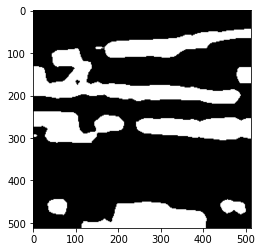

In [60]:
plt.imshow(score_sigmoid, cmap='gray')

In [63]:
tmp = pd.read_csv('./tmp.csv',header=None,sep='\t') # 之前baseline里做的那个
subm = pd.DataFrame(subm)

In [64]:
tmp

,0,1
0,R05K5826G4.jpg,17 34 529 34 1041 34 1553 34 2065 34 2577 34 3...
1,NAWXJVLK1Y.jpg,83 32 125 46 457 38 595 32 637 46 969 38 1107 ...
2,FLS7SRM1YA.jpg,331 44 497 16 843 44 1009 16 1355 44 1521 16 1...
3,XQLS9DXWMZ.jpg,18859 18 19371 18 19879 30 20391 30 20901 38 2...
4,J0P3C5OIB0.jpg,63 30 575 30 1087 30 1599 30 2111 30 2623 30 3...
...,...,...
2495,N1M7NL2Z84.jpg,15361 20 15873 20 16385 26 16897 26 17409 26 1...
2496,Y213H7PA9D.jpg,NaN
2497,VZPYOTOVMU.jpg,191541 6 192053 6 192563 8 193075 8 193587 8 1...
2498,L4SA2QHLCD.jpg,385 128 897 128 1409 128 1921 128 2433 128 294...


In [65]:
subm

,0,1
0,R05K5826G4.jpg,21 24 533 24 1045 24 1557 24 2069 24 2581 24 3...
1,NAWXJVLK1Y.jpg,471 6 983 6 1495 6 2007 6 2519 6 3031 6 3543 6...
2,FLS7SRM1YA.jpg,339 26 505 8 851 26 1017 8 1363 26 1529 8 1875...
3,XQLS9DXWMZ.jpg,21939 10 22451 10 22953 28 23465 28 23975 40 2...
4,J0P3C5OIB0.jpg,14359 4 14871 4 15379 10 15891 10 16401 16 169...
5,WSMA53E0I2.jpg,167079 4 167591 4 168101 8 168613 8 169125 8 1...
6,F2T71U9K5Q.jpg,203 60 365 28 445 24 715 60 877 28 957 24 1227...
7,RGRH9M6UG9.jpg,129 70 641 70 1153 70 1665 70 2177 70 2689 70 ...
8,NWEJUMFA3M.jpg,17 44 167 16 185 110 329 36 497 16 529 44 679 ...
9,YWKCCHWXBE.jpg,165977 2 166489 2 166999 10 167511 10 168023 1...


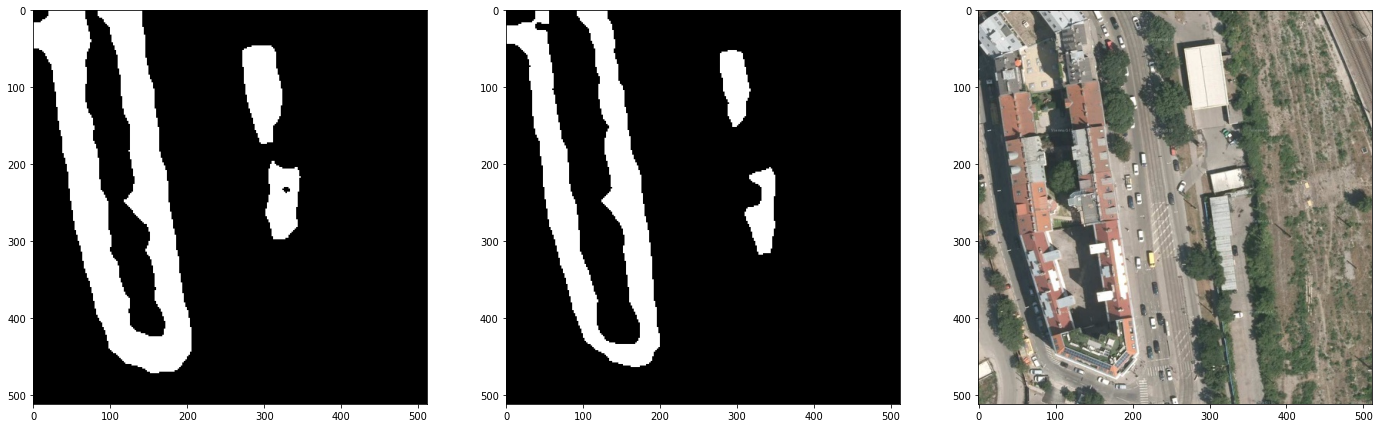

In [69]:
plt.figure(figsize=(24,8))
plt.subplot(131)
plt.imshow(rle_decode(tmp[1].fillna('').iloc[0]), cmap='gray')
plt.subplot(132)
plt.imshow(rle_decode(subm[1].fillna('').iloc[0]), cmap='gray')
plt.subplot(133)
plt.imshow(cv2.imread(PATH+'test_a/' + subm[0].iloc[0]))

好像是有一点点变化